In [23]:
# Cell 1: imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

# Create models folder
os.makedirs("models", exist_ok=True)


In [24]:
fake_df = pd.read_csv(r"C:\Users\ishik\Downloads\Fake news detection System\Fake (1).csv")
true_df = pd.read_csv(r"C:\Users\ishik\Downloads\Fake news detection System\True (1).csv")

print("Fake shape:", fake_df.shape)
print("True shape:", true_df.shape)

Fake shape: (23481, 4)
True shape: (21417, 4)


In [25]:
# Cell 3: quick inspection and prepare labels
display(fake_df.head())
display(true_df.head())

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [26]:
# The datasets often have 'text' or 'title' columns. We'll construct a 'text' column robustly.
def build_text_column(df):
    # common column names: 'text', 'title', 'article', 'content'
    if 'text' in df.columns:
        return df['text'].astype(str)
    cols = []
    for c in ['title', 'headline', 'content', 'article']:
        if c in df.columns:
            cols.append(df[c].astype(str))
    if cols:
        return cols[0] if len(cols)==1 else cols[0].str.cat(cols[1:], sep=' ')
    # fallback: concat all string columns
    str_cols = [df[c].astype(str) for c in df.columns if df[c].dtype == object]
    if str_cols:
        return str_cols[0].str.cat(str_cols[1:], sep=' ')
    raise ValueError("No text-like columns found in the dataset.")
    
fake_df['text'] = build_text_column(fake_df)
true_df['text'] = build_text_column(true_df)

fake_df = fake_df[['text']].copy()
true_df = true_df[['text']].copy()

fake_df['label'] = 'fake'
true_df['label'] = 'true'

In [27]:
# Cell 4: combine and shuffle
df = pd.concat([fake_df, true_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print("Combined shape:", df.shape)
df['label_num'] = df['label'].map({'true':0, 'fake':1})
df.head()

Combined shape: (44898, 2)


,text,label,label_num
0,"21st Century Wire says Ben Stein, reputable pr...",fake,1
1,WASHINGTON (Reuters) - U.S. President Donald T...,true,0
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,true,0
3,"On Monday, Donald Trump once again embarrassed...",fake,1
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",true,0


In [28]:
# Cell 5: split
X = df['text'].values
y = df['label_num'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Train size:", len(X_train), "Test size:", len(X_test))


Train size: 35918 Test size: 8980


In [29]:
# Cell 6: vectorize
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7, ngram_range=(1,1), max_features=10000)
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)
print("TF-IDF shape:", tfidf_train.shape)

TF-IDF shape: (35918, 10000)


In [30]:
# Cell 7: train
clf = PassiveAggressiveClassifier(max_iter=1000, random_state=42)
clf.fit(tfidf_train, y_train)

,C,1.0
,fit_intercept,True
,max_iter,1000
,tol,0.001
,early_stopping,False
,validation_fraction,0.1
,n_iter_no_change,5
,shuffle,True
,verbose,0
,loss,'hinge'
,n_jobs,None


Accuracy: 0.9928730512249443

Classification Report:
               precision    recall  f1-score   support

        true       0.99      0.99      0.99      4284
        fake       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



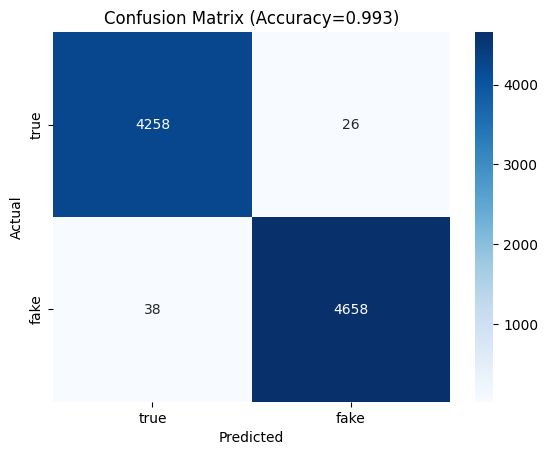

In [31]:
# Cell 8: evaluate
y_pred = clf.predict(tfidf_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['true','fake']))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['true','fake'], yticklabels=['true','fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Accuracy={acc:.3f})")
plt.show()

In [36]:
# Cell 9: save model and vectorizer
model_path = "model.pkl"
vec_path = "vectorizer.pkl"

import pickle, gzip

with gzip.open("model.pkl.gz", "wb") as f:
    pickle.dump(clf, f)

with gzip.open("vectorizer.pkl.gz", "wb") as f:
    pickle.dump(tfidf, f)

print("✅ Model and vectorizer saved successfully (compressed)")

✅ Model and vectorizer saved successfully (compressed)


In [33]:
print(type(clf))
print(type(tfidf))

<class 'sklearn.linear_model._passive_aggressive.PassiveAggressiveClassifier'>
<class 'sklearn.feature_extraction.text.TfidfVectorizer'>


In [34]:
print("Saved model to:", model_path)
print("Saved vectorizer to:", vec_path)

Saved model to: models/model.pkl
Saved vectorizer to: models/vectorizer.pkl


In [35]:
import os
print(os.path.getsize("model.pkl.gz")/1024/1024, "MB")
print(os.path.getsize("vectorizer.pkl.gz")/1024/1024, "MB")

0.07391357421875 MB
0.10901165008544922 MB
